# Analyze score distributions of pairs of the Balance Faces in the Wild (BFW) dataset.

Load table in `data/bfw-datatable.pkl` to extract all features and store in the datatable. Overwrites the table to `data/bfw-datatable.pkl`.
using fundalmental signal detection theory lists of feature pairs

## Add project code to PYTHONPATH, if not already there
Check that _path_package_ is set to _code_ directory on respective system

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load out custom tool for loading and processing the data
from iotools import load_bfw_datatable, makedir
from visualization import set_defaults, box_plot
from analysis import violin_plot

In [14]:
font = set_defaults()

In [15]:
bfw_version = "0.1.5"
dir_data = '../../data/bfw/'
dir_features = f'{dir_data}features/sphereface/'
f_datatable = f'{dir_data}meta/bfw-v0.1.5-datatable.pkl'
use_feature = 'sphereface'

dir_results = f"../../results/{use_feature}/"
makedir(dir_results)

/Users/jrobby/WORK/src/facebias/code/facebias/iotools.py:21: UserWarning: Directory ../../results/sphereface/ exists
  warnings.warn(f"Directory {din} exists")


## Load the data

Read in the data as a pandas.DataFrame and show the first few rows.

In [16]:
data = load_bfw_datatable(f_datatable , cols=['p1', 'p2', 'a1', 'a2', 'label', 'g1', 'g2', use_feature])
data['score'] = data[use_feature]
del data[use_feature]
data.label = data.label.astype(int)
data.head()

,p1,p2,label,a1,a2,g1,g2,score
0,asian_females/n000009/0010_01.jpg,asian_females/n000009/0043_01.jpg,1,AF,AF,F,F,0.392526
1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0120_01.jpg,1,AF,AF,F,F,0.354262
2,asian_females/n000009/0010_01.jpg,asian_females/n000009/0122_02.jpg,1,AF,AF,F,F,0.302028
3,asian_females/n000009/0010_01.jpg,asian_females/n000009/0188_01.jpg,1,AF,AF,F,F,-0.009217
4,asian_females/n000009/0010_01.jpg,asian_females/n000009/0205_01.jpg,1,AF,AF,F,F,0.132534


In [17]:
if 'score' not in data:
    warnings.warn('scores not stored in table. See Demo 1 in notebooks/ before proceedings')

In [18]:
classes = np.unique(list(np.unique(data.a1)) + list(np.unique(data.a2)))
n_classes = len(classes)
xlabels = {'A': 'Asian', 'B': 'Black', 'I': 'Indian', 'W': 'White'}
ylabels = {'M': 'Male', 'F': 'Female'}
abbr_attributes = []
for e in xlabels.keys():
    for g in ylabels.keys():
        abbr_attributes.append(e+g)
abbr_attributes.sort()
        
opts = [{'color': 'g', 'alpha': 0.7, 'norm_hist': True}, {'color': 'r', 'alpha': 0.7, 'norm_hist': True}]
print(f"there are {n_classes} types: {classes}")

there are 8 types: ['AF' 'AM' 'BF' 'BM' 'IF' 'IM' 'WF' 'WM']


Processing: AF


NameError: name 'font' is not defined

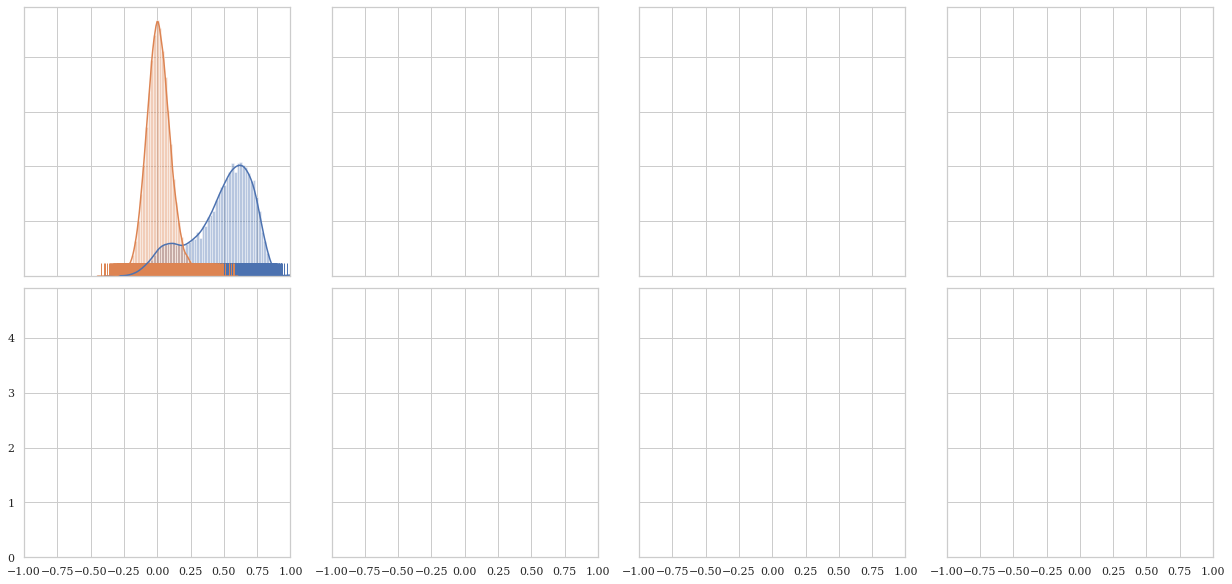

In [19]:
fig, ax = plt.subplots(2, int(n_classes / 2), sharex='all', sharey='all', figsize=(17, 2 * n_classes / 2), constrained_layout=True)


for i, (cur_class, axi) in enumerate(zip(classes, ax.flat)):
    print("Processing: {}".format(cur_class))
    df_cur = data.loc[data.a1==cur_class][['label', 'score']]
    sns.distplot(df_cur.loc[df_cur.label == 1, 'score'], np.linspace(-1.0, 1.0, 100), ax=axi, *opts[0])
    sns.distplot(df_cur.loc[df_cur.label == 0, 'score'], np.linspace(-1.0, 1.0, 100), ax=axi, *opts[1])
    #axi.set_xticks((0.0,0.25,0.5,0.75,1.0))
    axi.set_xlim((-1.0,1.0))
    if i > 3:
        axi.set_xlabel(xlabels[cur_class[0]])
        
    else:
        axi.set_xlabel(None)
    for tick in axi.yaxis.get_major_ticks():
        tick.label1.set_visible(False)
    if not np.mod(i, int(n_classes / 2)):
        axi.set_ylabel(ylabels[cur_class[1]], fontdict={k.replace('font.',''): v for k, v in font.items() if k != 'font.serif'})
        
    sns.despine(ax=axi)


plt.legend(['True Match', 'Imposter'], fontsize=font['font.size'], loc='best')
fig.suptitle('Signal Detection Curve per Subgroup', fontsize=font['font.size'])
plt.tight_layout()
plt.savefig(f'{dir_results}sdm-plots-v{bfw_version}.pdf', transparent=True)

## Aligned SDM Curves
As means of viewing shifts in plots, hinting the optimal thresholds are variable, the following figure uses a single column.

/Users/jrobby/miniconda3/envs/fairness/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


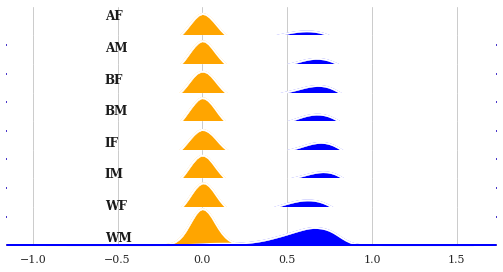

In [20]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data, row="a1", hue="label", aspect=15, height=.5, palette={1: "blue", 0: "orange"})

# Draw the densities in a few steps
g.map(sns.kdeplot, "score", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

ax = plt.gca()

dims = plt.gcf().get_size_inches() # (width, height) 
step_size = np.linspace(.2, dims[1]*1.5, len(abbr_attributes))
[ax.text(.2, step_size[i], txt, fontweight="bold", color='k', ha="left", va="center", transform=ax.transAxes) for i, txt in enumerate(reversed(abbr_attributes))]
type(abbr_attributes)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.savefig(f'{dir_results}sdm-plots-view2-v{bfw_version}.pdf', transparent=True)

# Box plots
Depict median, 25 and 75 percentile, max, min, and outliers.

In [20]:
new_labels = ['Imposter', 'Genuine']
palette={new_labels[0]: "orange", new_labels[1]: "lightblue"}
data.label = data.label.astype(int)
data['Tag'] = data.label
data.loc[data.label==0, 'Tag'] = new_labels[0]
data.loc[data.label==1, 'Tag'] = new_labels[1]

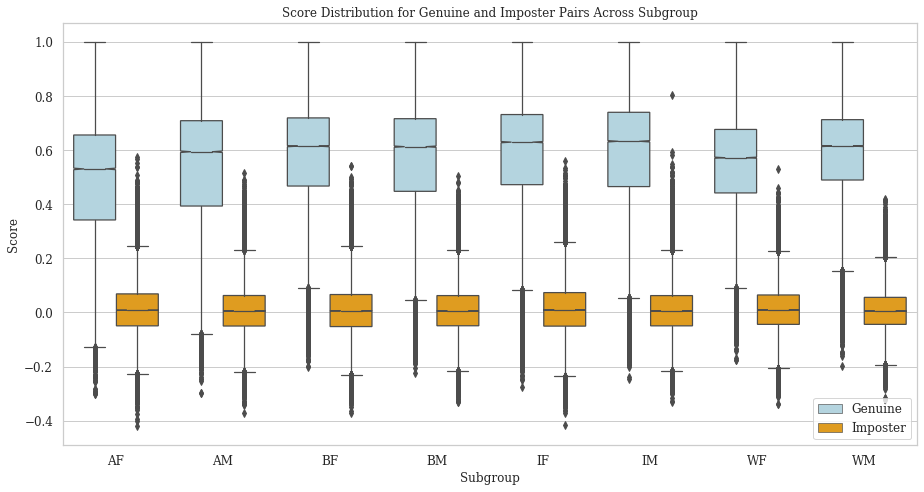

In [21]:
box_plot(data, f'{dir_results}boxplots-v{bfw_version}.pdf')

# Violin Plot

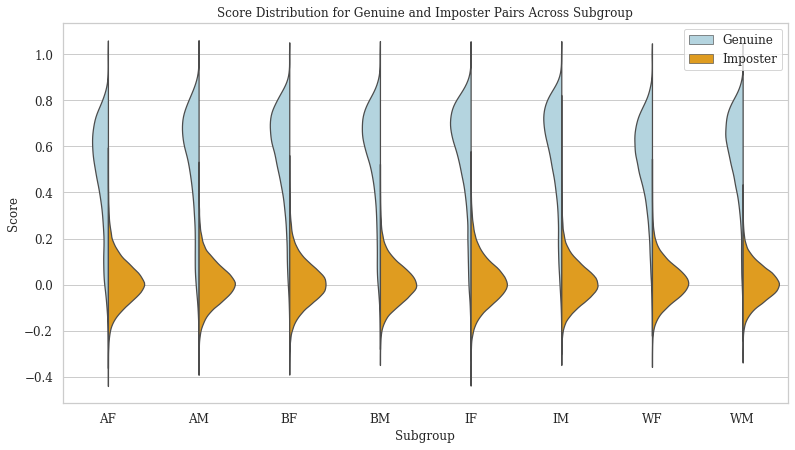

In [34]:
violin_plot(data, f'{dir_results}violinplots-{bfw_version}.pdf')